In [1]:
import glob
import os
import sys
from copy import deepcopy
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pyart
import xarray as xr

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

# %matplotlib widget


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



#### NOTE:

I tried converting NEXRAD level II files to cfradial format using PyART and then read those to grid using RadxPid.

Apparently, RadxPid does not like the PyART cfradial files. Better convert NEXRAD -> cfradial using RadxConvert

#### Let's try plotting the PID output now

In [2]:
import pyart
import matplotlib.colors as colors
import matplotlib as mpl

In [3]:
pid_files = sorted(glob.glob('/Users/ms/Desktop/RadxPid_KTLX_May192013/PID_polar/20130519/*.nc'))

In [3]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))



hid_colors = ['#D7CCC8', 'FFCCBC', 'FF8A65', 'BF360C', 'F44336',
              'FFEE58', '94D82D', '51CF66', '2B8A3E', '66D9E8',
              '228BE6', '364FC7', 'EEBEFA', 'F783AC', 'F8F9FA',
              'F8F9FA','F8F9FA','F8F9FA']


cmaphid_colors = [hex_to_rgb(color) for color in hid_colors]
cmaphid = [[t/255 for t in x] for x in cmaphid_colors]

cmapncarpid = colors.ListedColormap(cmaphid)
plt.register_cmap(name='ncarpid',cmap=cmapncarpid)
bounds = np.linspace(1,19,19)
norm = colors.BoundaryNorm(bounds,cmapncarpid.N)

In [371]:
# As per NCAR PID algorithm, RadxPid generates 18 hydrometeor categories

# (1) -> Cloud (CL), (2) -> Drizzle (DRZ), (3) -> Light_Rain (LR), (4) -> Moderate_Rain (MR), 
# (5) -> Heavy_Rain (HR), (6) -> Hail (HA), (7) -> Rain_Hail_Mixture (RH), (8) -> Graupel_Small_Hail (GSH),
# (9) -> Graupel_Rain (GRR), (10) -> Dry_Snow (DS), (11) -> Wet_Snow (WS), (12) -> Ice_Crystals (IC),
#(13) -> Irreg_Ice_Crystals (IIC), (14) -> Supercooled_Liquid_Droplets (SLD)
def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.5,18.6,1))
    cb.ax.set_yticklabels(['CL', 'DRZ', 'LR', 'MR','HR', 'HA', 'RH','GSH', 'GRR', 'DS',
                           'WS', 'IC', 'IIC', 'SLD', 'BGS', 'TRIP2', 'GCL', 'SAT'],fontsize=14)
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

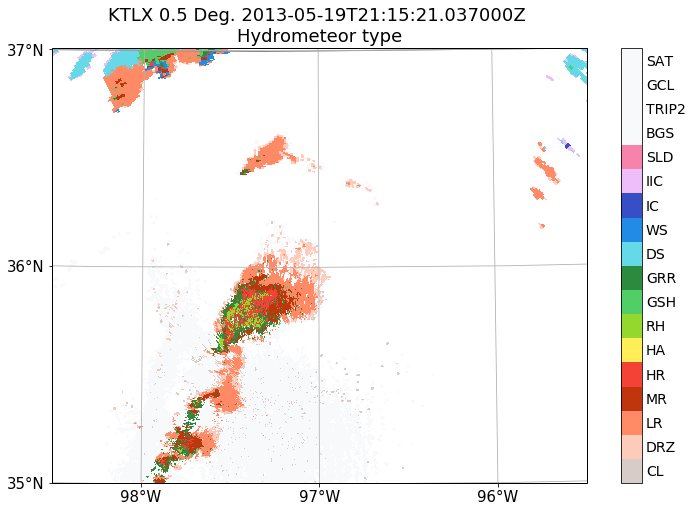

In [372]:
radar = pyart.io.read(pid_files[17])
display = pyart.graph.RadarMapDisplay(radar)

fig,ax = plt.subplots()

display.plot_ppi_map('PID',0,min_lon=-98.5,max_lon=-95.5,min_lat=35,max_lat=37,cmap='ncarpid',ax=ax,vmin=1,vmax=19,mask_outside=True,norm=norm)
display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0])

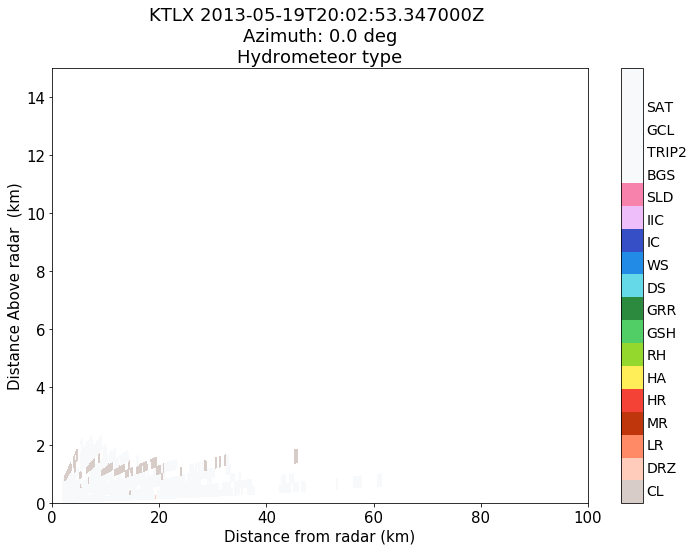

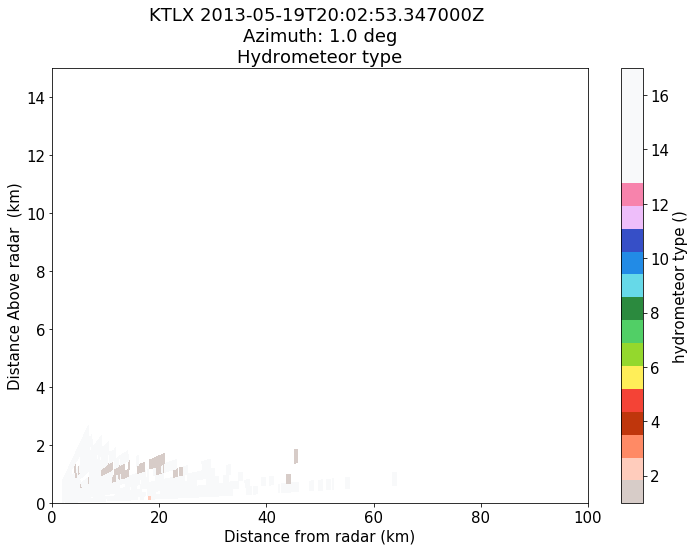

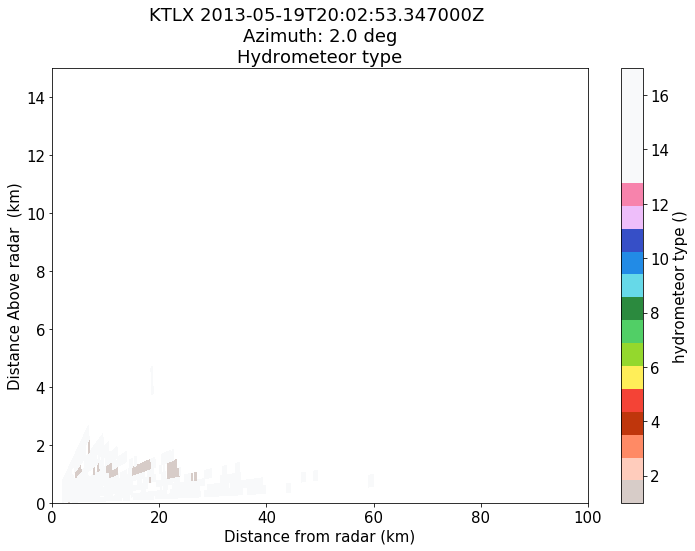

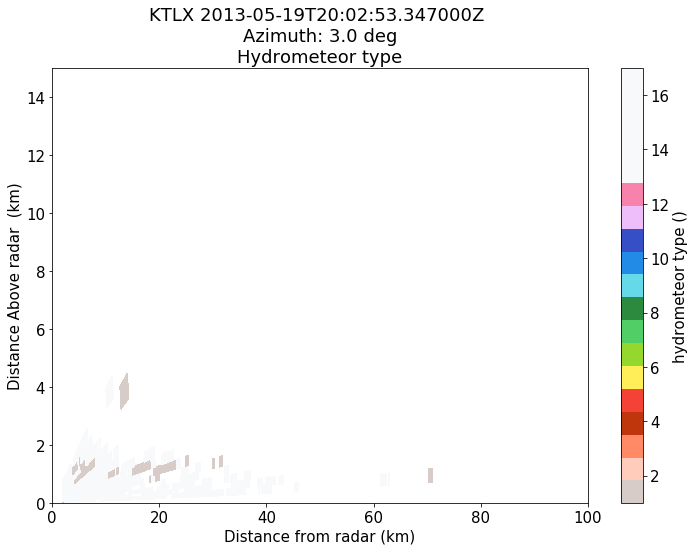

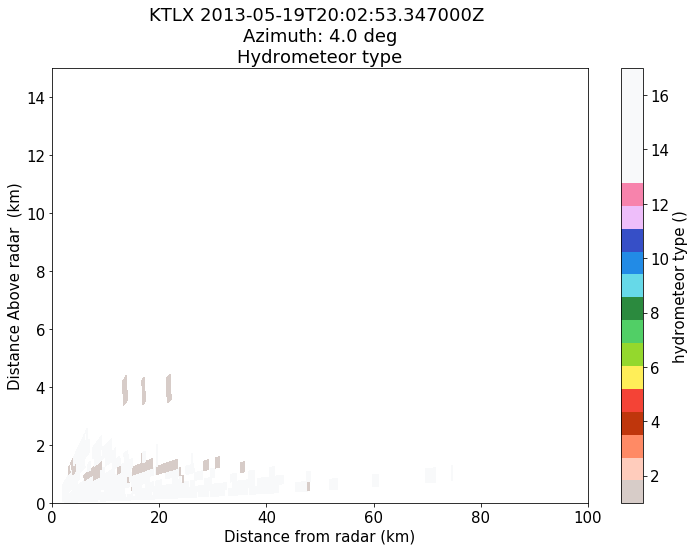

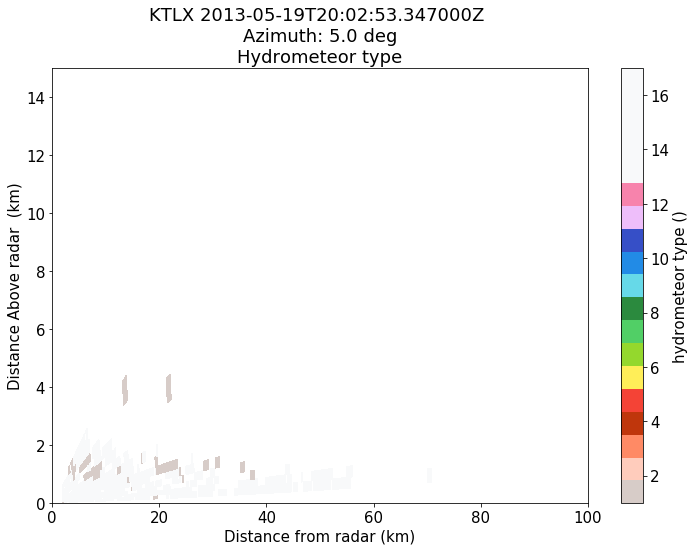

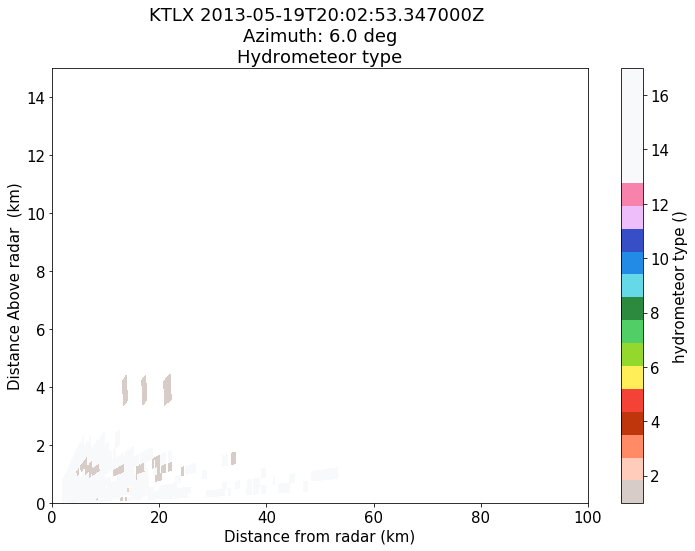

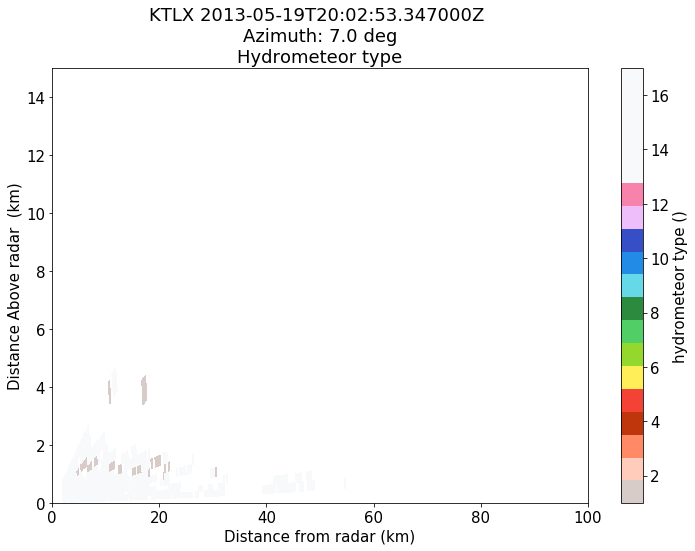

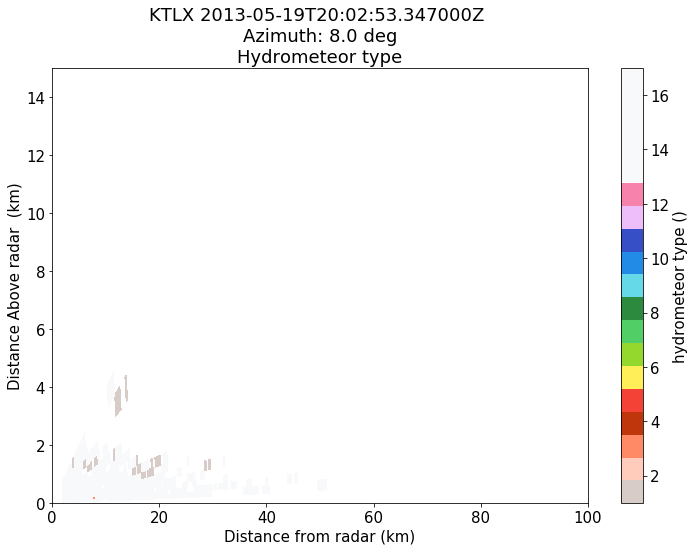

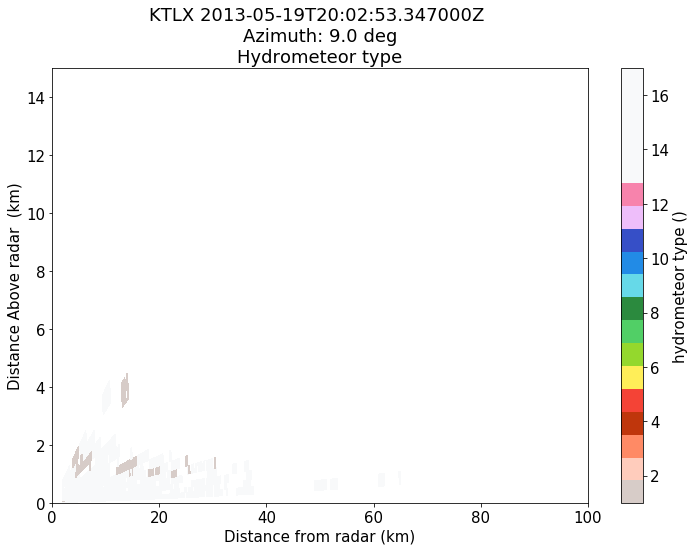

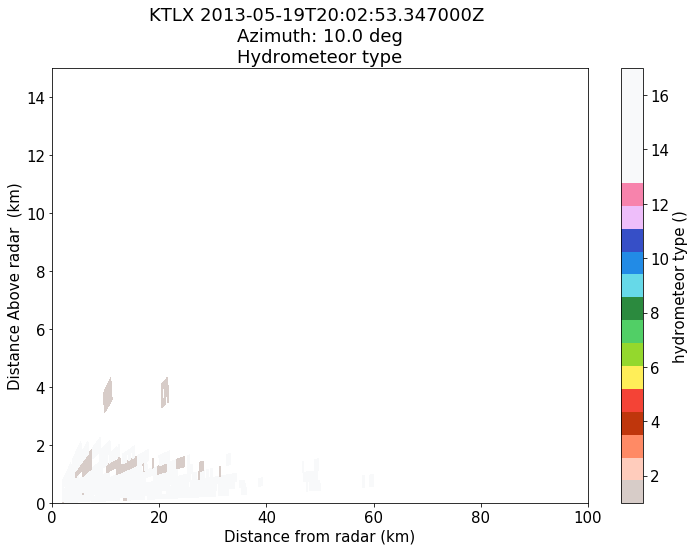

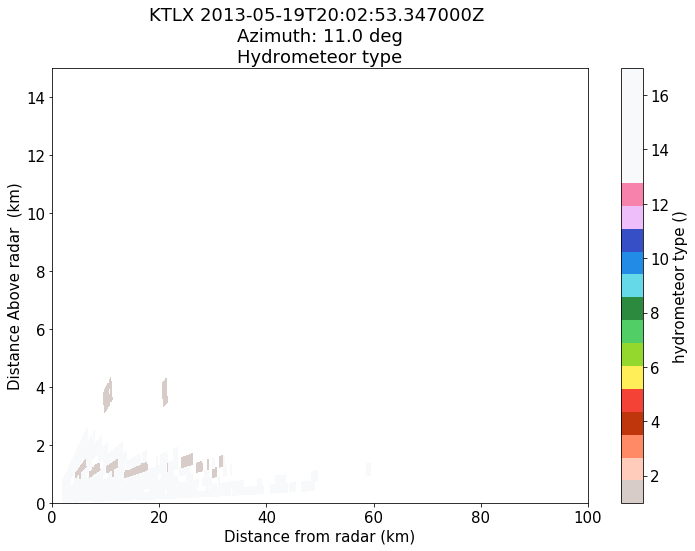

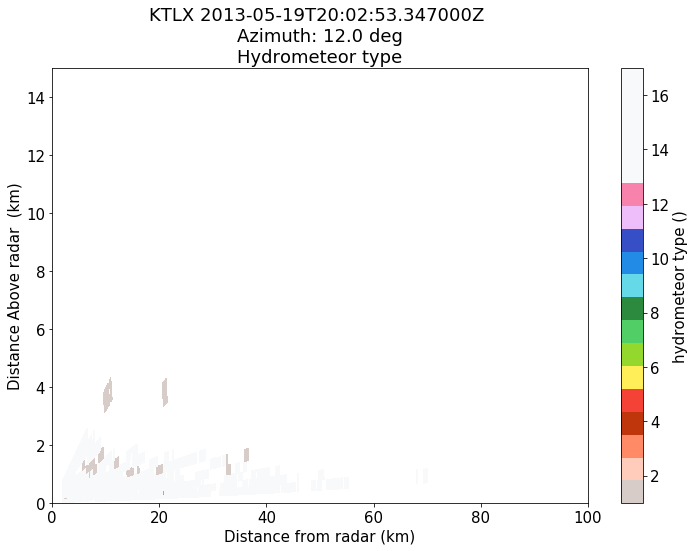

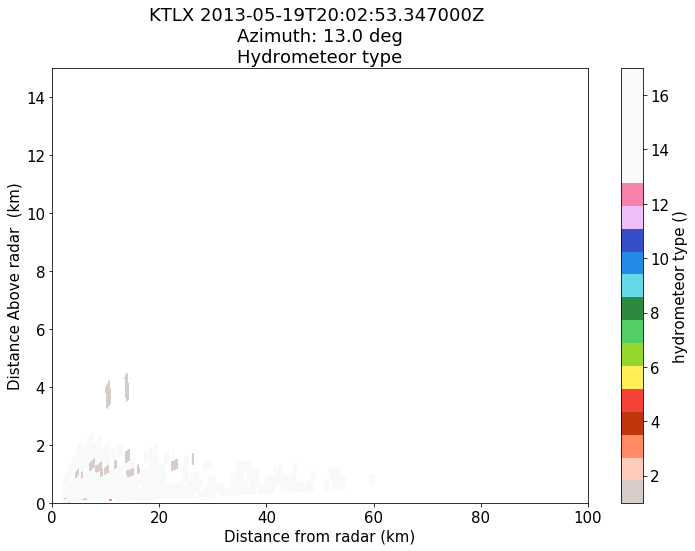

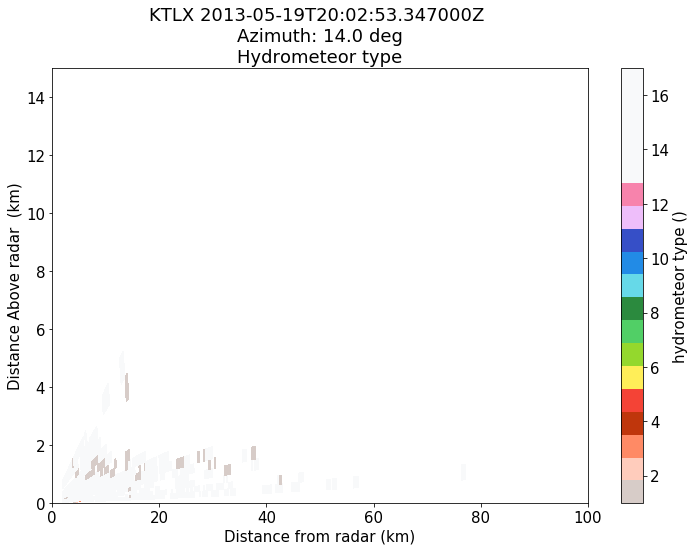

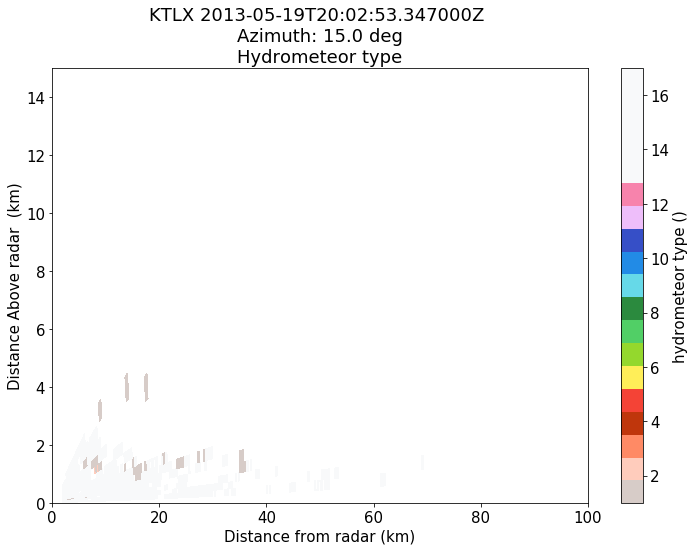

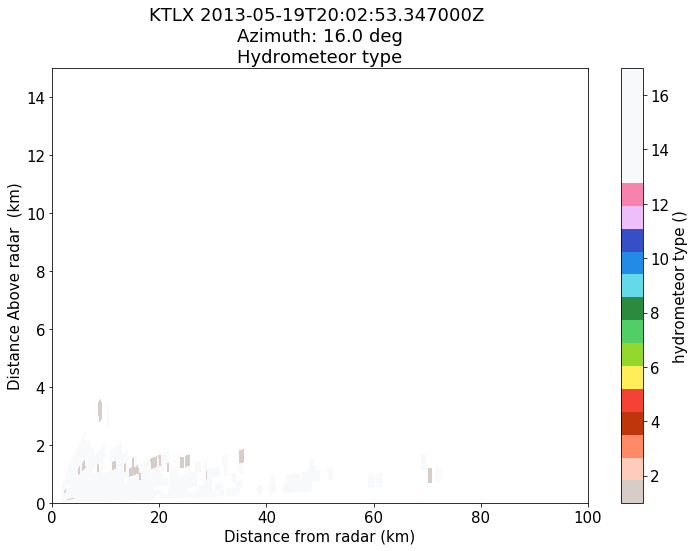

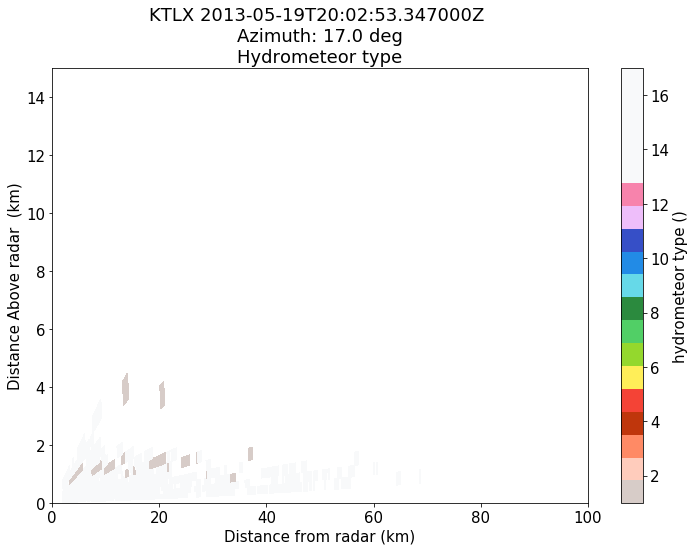

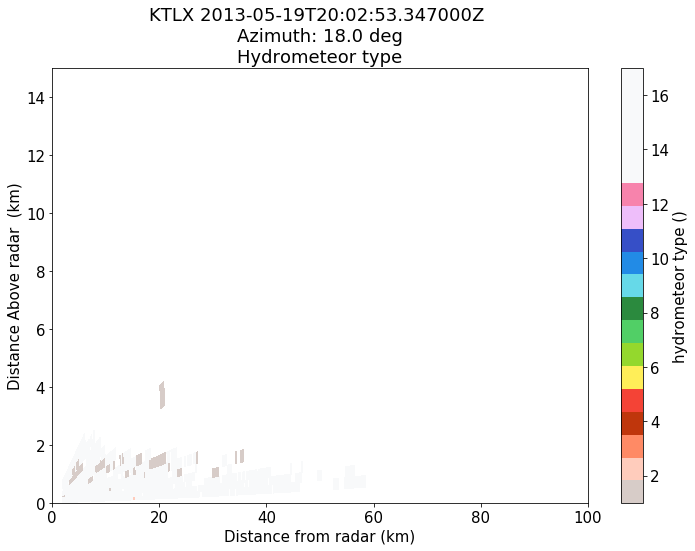

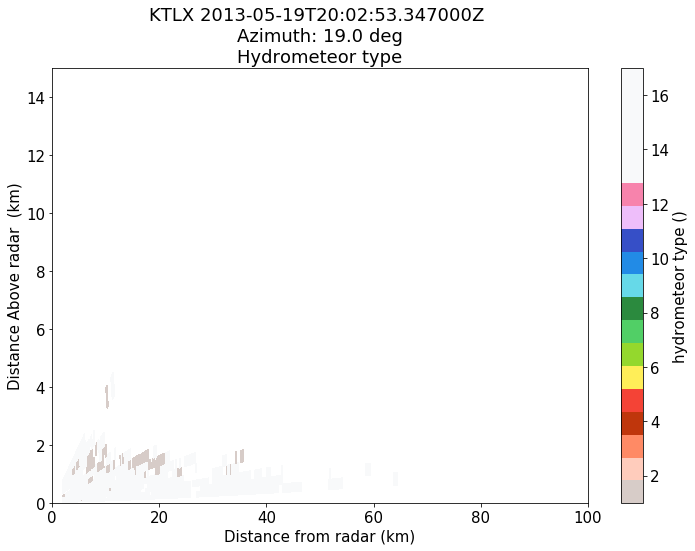

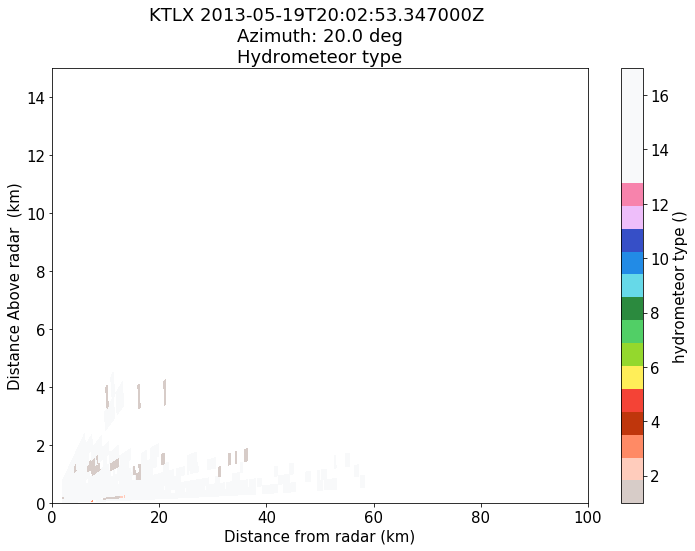

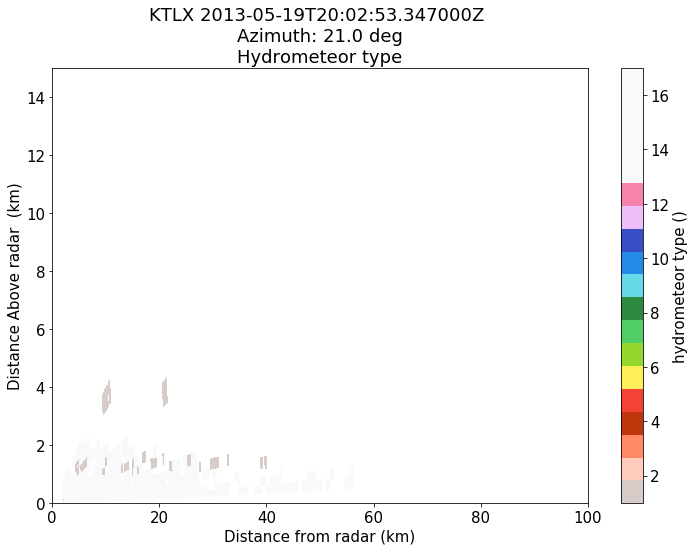

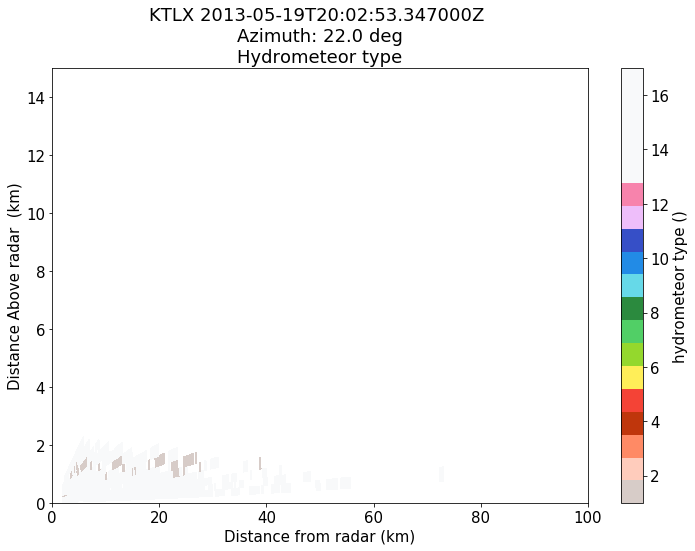

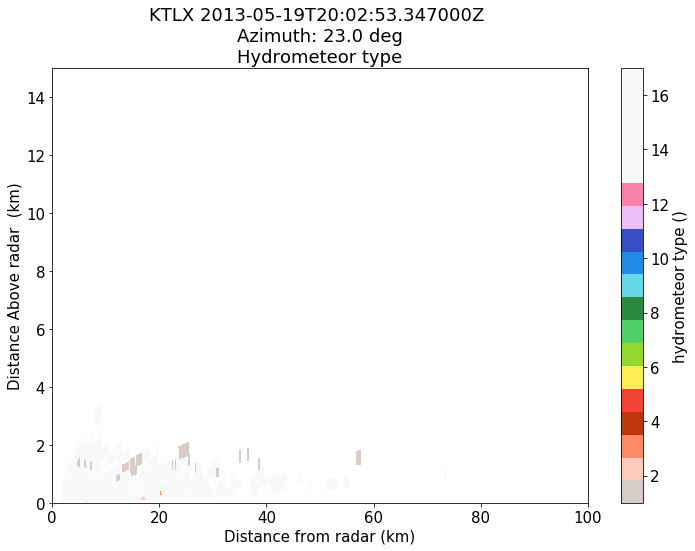

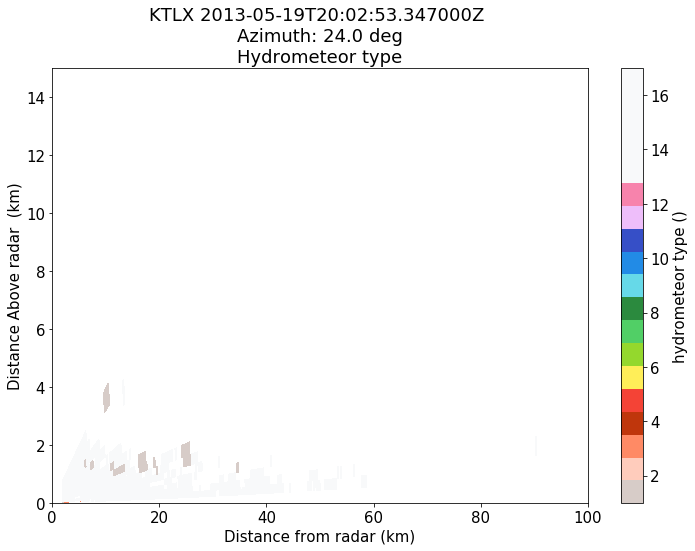

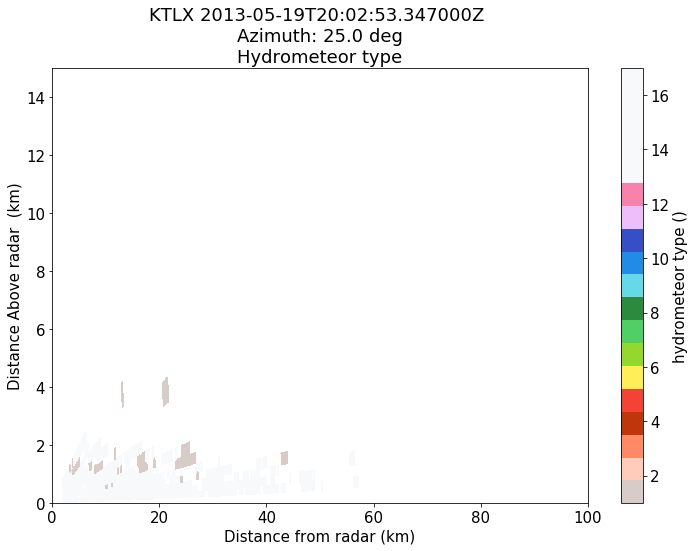

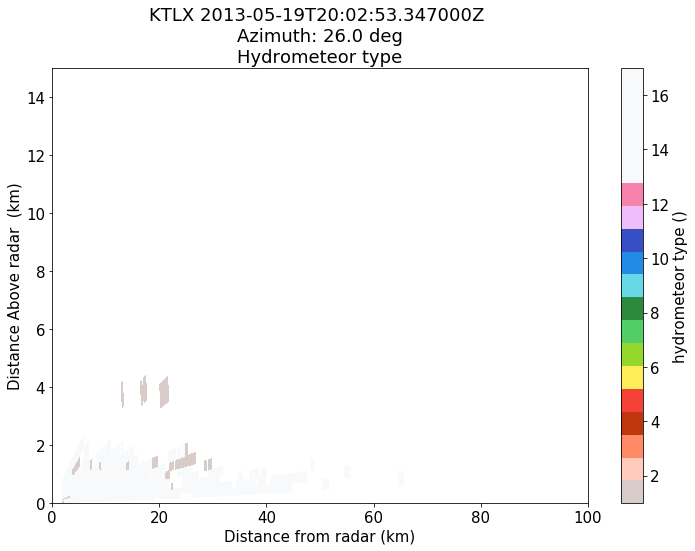

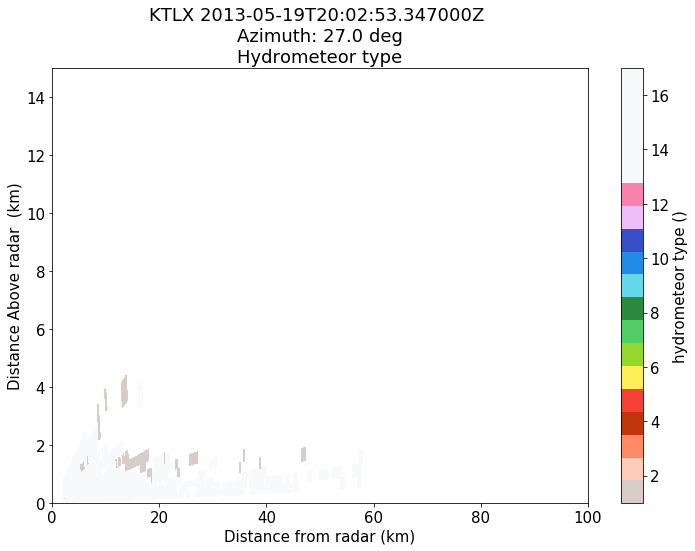

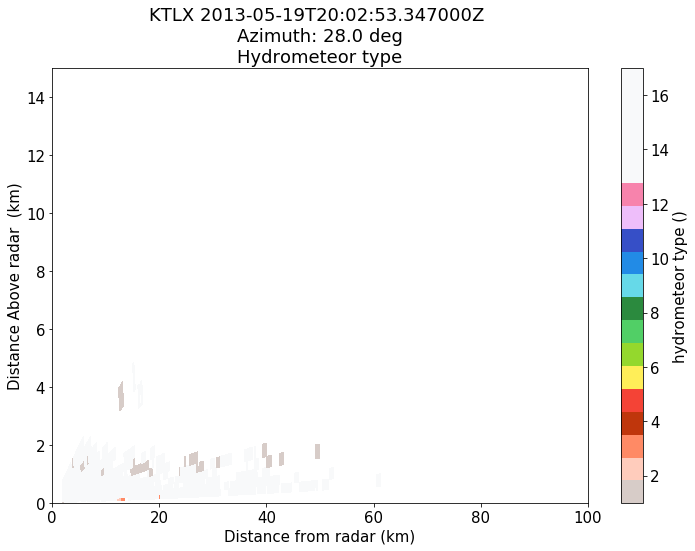

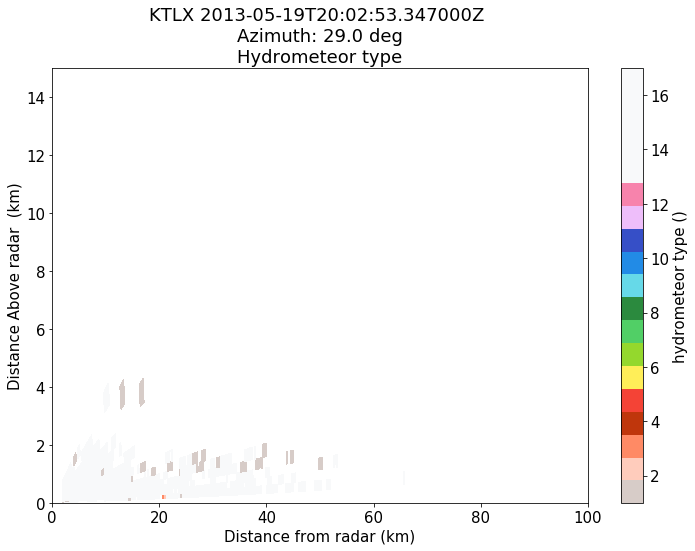

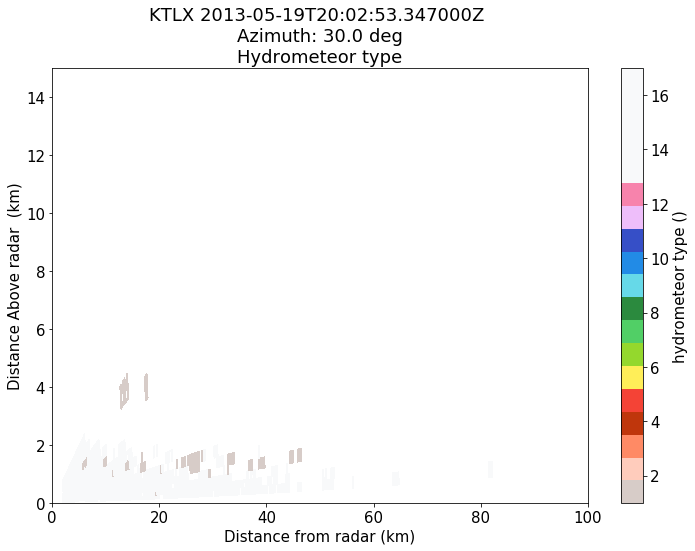

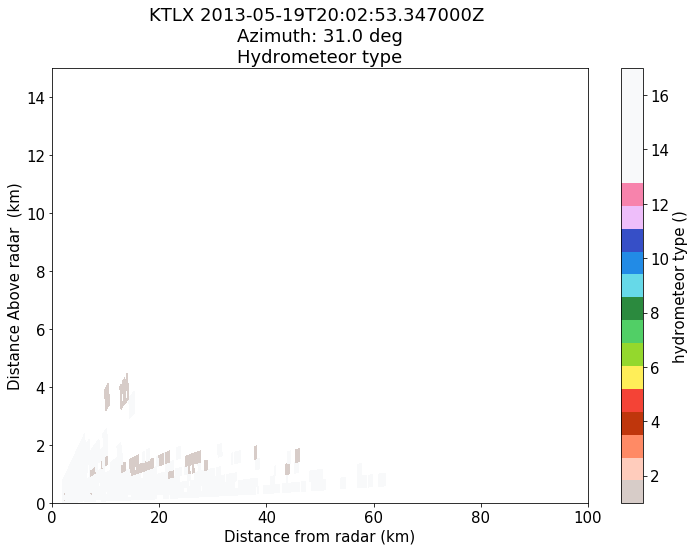

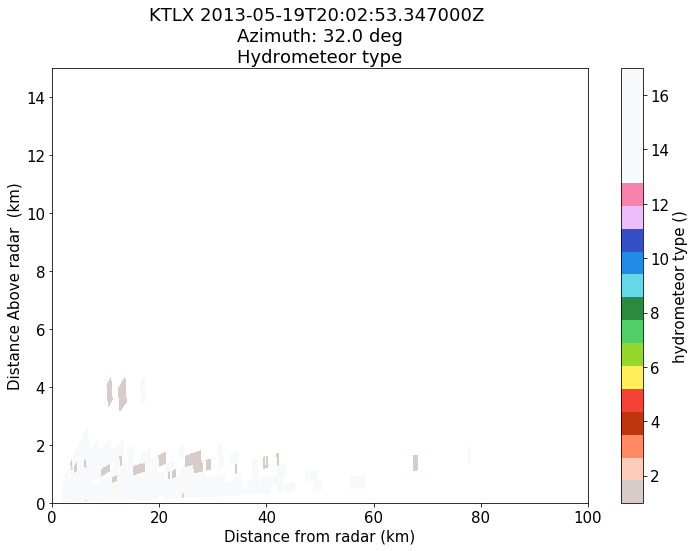

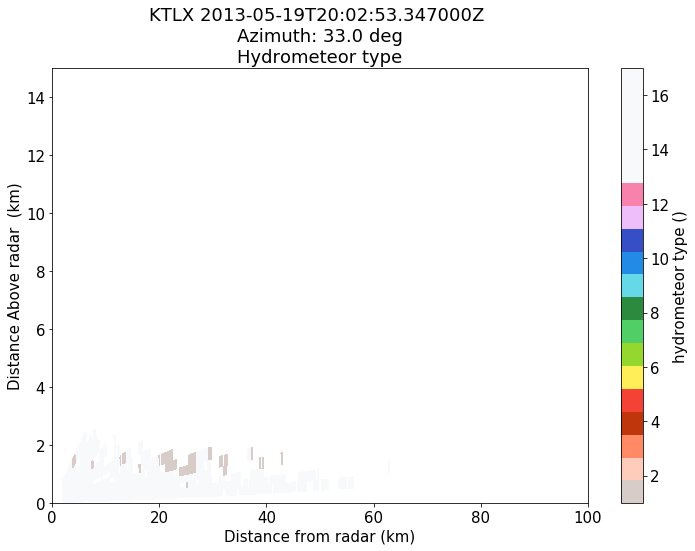

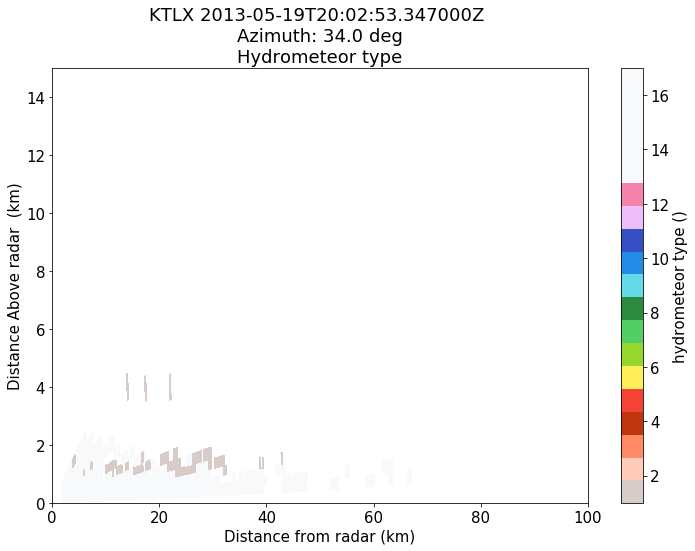

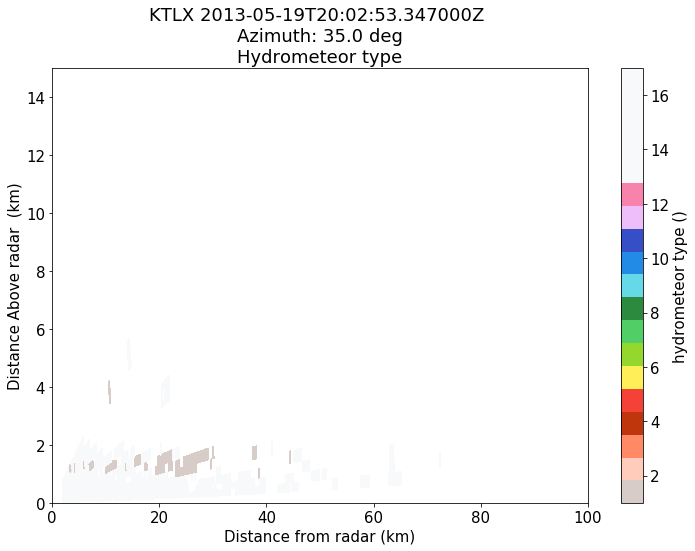

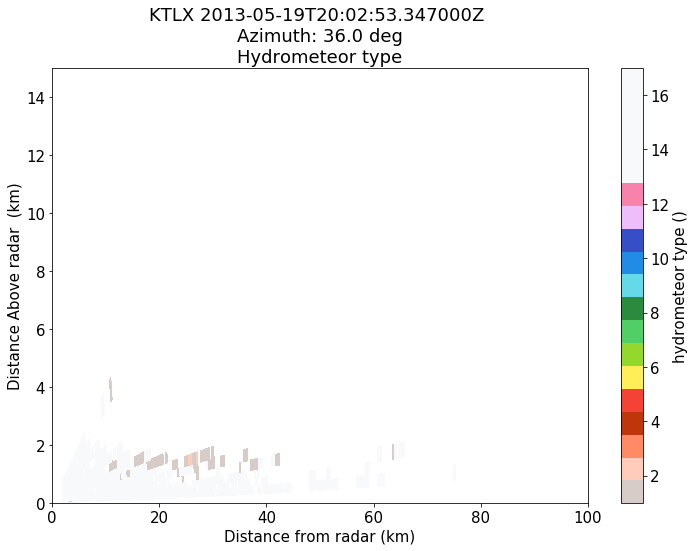

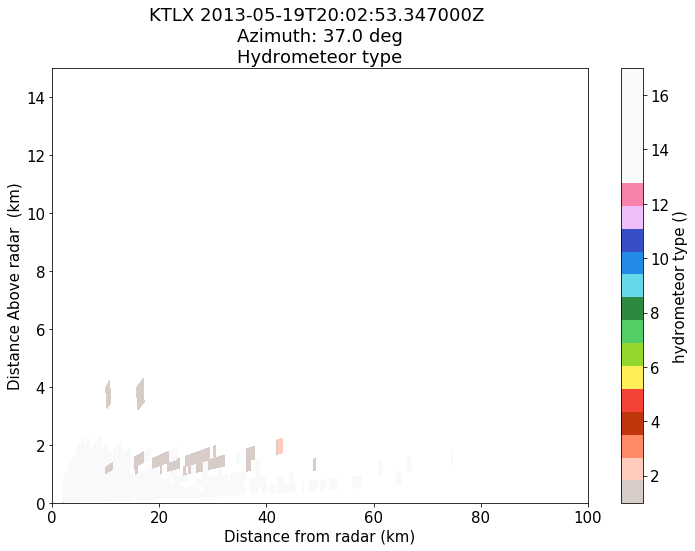

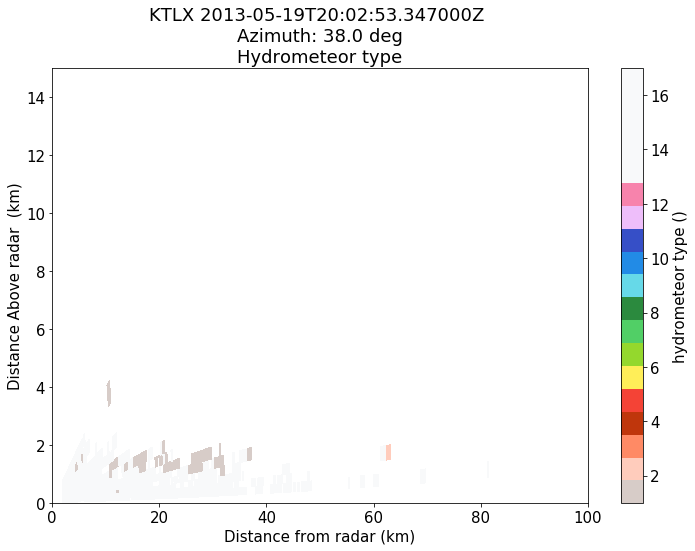

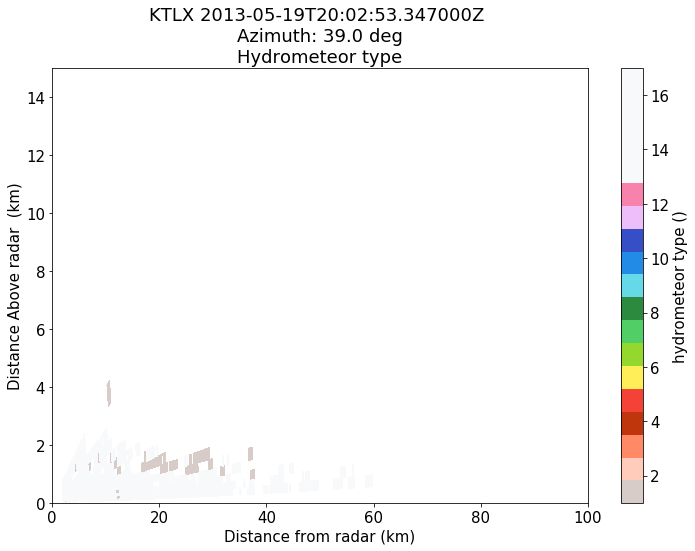

In [7]:
# radar = pyart.io.read(pid_files[0])
# display = pyart.graph.RadarMapDisplay(radar)

# for i in range(0,40):
#     fig,ax = plt.subplots()
#     display.plot_azimuth_to_rhi('PID',i,mask_outside=True,vmin=1,vmax=17,cmap=cmapncarpid,ax=ax)
#     display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0])
#     ax.set_ylim(0,15)
#     ax.set_xlim(0,100)
#     plt.show()

#### Enters xarray

In [4]:
import xarray as xr
from xrviz.dashboard import Dashboard

In [5]:
data = xr.open_mfdataset('/Users/ms/Desktop/RadxPid_KTLX_May192013/PID_cart/20130519/small_domain/*.nc',parallel=True)

In [6]:
data['PID'] = data['PID'].where(data['PID'] >=1)

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


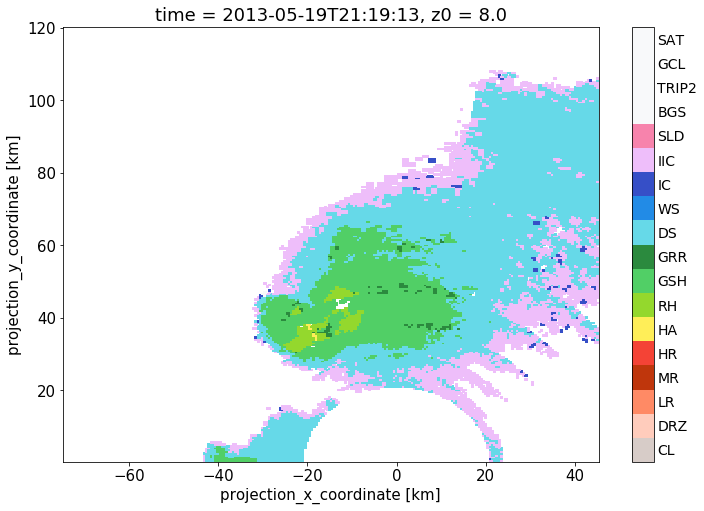

In [375]:
pid_plot = data['PID'].isel(z0=15,time=17).plot(cmap='ncarpid',norm=norm)
cbar = pid_plot.colorbar
cb = adjust_fhc_colorbar_for_pyart(cbar)
# cbar = adjust_fhc_colorbar_for_pyart(cbar)

In [7]:
initial_params = {# Select Variable
                  'Variables': 'PID',

                  # Set Coords
                  'Set Coords': ['lat0', 'lon0'],

                  # Axes
                  'x': 'lon0',
                  'y': 'lat0',
                  'z': 'animate',

                  # Style
                  'height': 300,
                  'width': 650,
                  'colorbar': True,
                  'cmap': ''     
}

# pass the data to Dashboard
dash = Dashboard(data, initial_params=initial_params)
dash.show()

Launching server at http://localhost:58955


/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/anaconda3/envs/segmentation/lib/python3.6/site-packages/bokeh/core/property/bases.py:237: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return new == old
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_

In [ ]:
# dash.panel[0][0][3][2][0] = pn.widgets.Select(name='cmap',value='ncarpid',options=['ncarpid'])

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


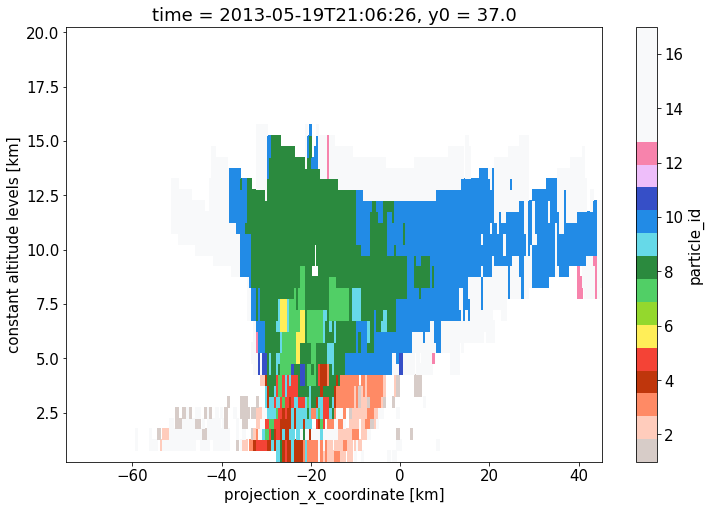

In [72]:
# data['PID'].isel(time=14).sel(y0=37,method='nearest').plot(cmap=cmapncarpid,vmin=1,vmax=17)

In [241]:
# rasterized_pid = data['PID'].hvplot.image(groupby=['time','z0'],cmap=cmapncarpid,rasterize=True)
# rasterized_pid

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


:DynamicMap   [time,z0]
   :Image   [x0,y0]   (PID)

In [15]:
# data1 = xr.open_mfdataset('/Users/ms/Desktop/RadxPid_KTLX_May192013/gridded_other_fields/20130519/*.nc', parallel=True)

In [16]:
# data1['ZDR'].isel(time=15,z0=10).plot(vmin=-2,vmax=7,cmap='pyart_RefDiff')
# plt.axhline(y=37)

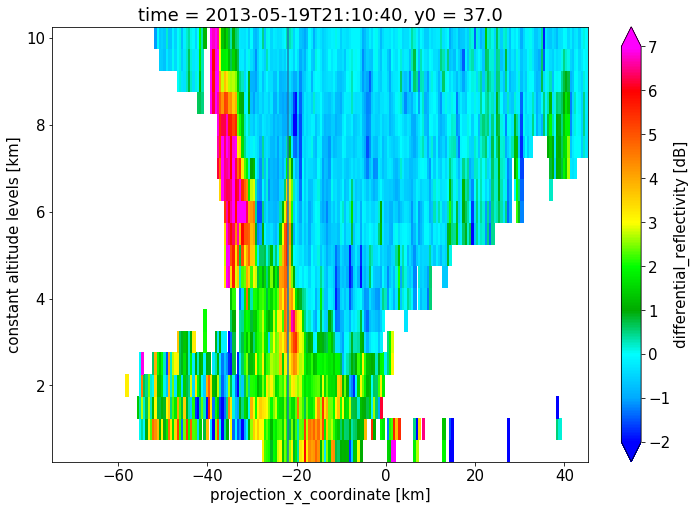

In [56]:
# data1['ZDR'].isel(time=15).sel(y0=37).plot(vmin=-2,vmax=7,cmap='pyart_RefDiff')
# plt.axvline(x=-22)

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


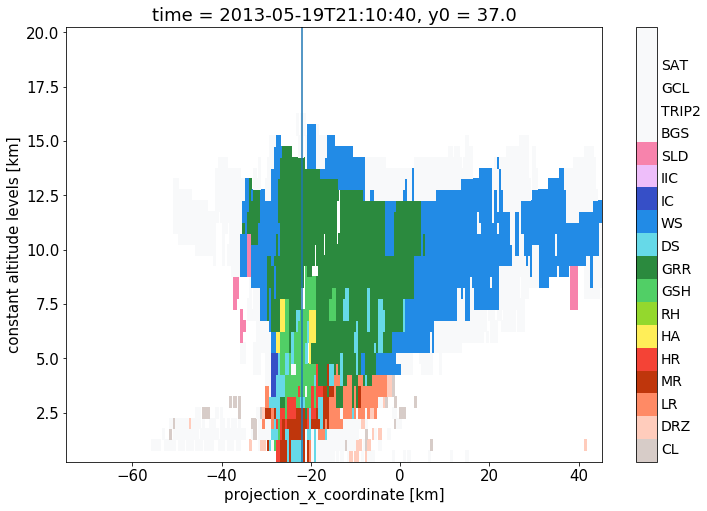

In [57]:
# pid_plot = data['PID'].isel(time=15).sel(y0=37,method='nearest').plot(cmap=cmapncarpid,vmin=1,vmax=17)
# cbar = pid_plot.colorbar
# cb = adjust_fhc_colorbar_for_pyart(cbar)
# plt.axvline(x=-22)

In [362]:
# tt = xr.open_dataset('/Users/ms/Desktop/RadxPid_KTLX_May192013/gridded_KTLX/20130519/ncf_20130519_220609.nc')

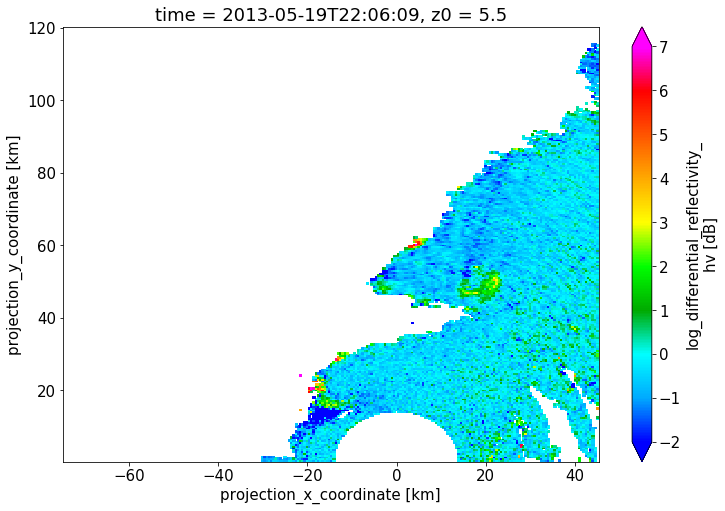

In [365]:
# tt['differential_reflectivity'].isel(time=0,z0=10).plot(vmin=-2,vmax=7,cmap='pyart_RefDiff')

In [378]:
# radar = pyart.io.read('/Users/ms/Desktop/RadxPid_KTLX_May192013/cfradial_pyart_converted/KTLX20130519220203.nc')
# grid = pyart.map.grid_from_radars(radar,grid_limits=((0,20000),(0,120000),(-75000,45000)),grid_shape=(41,241,241))

/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


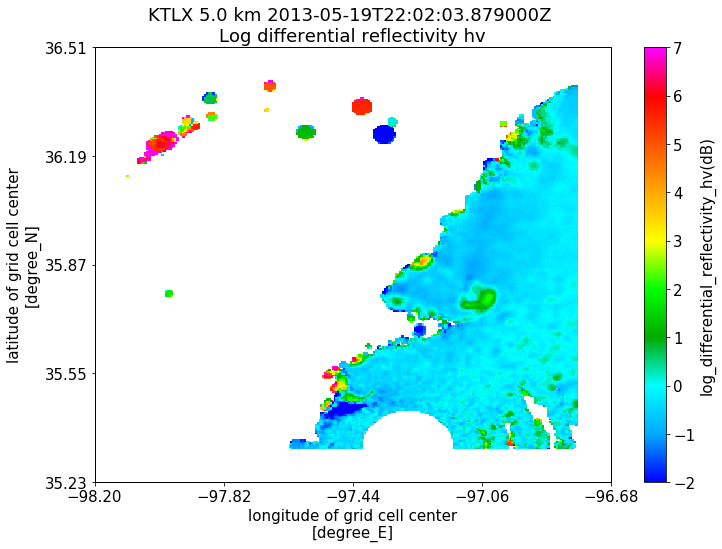

In [379]:
# display = pyart.graph.GridMapDisplay(grid)
# display.plot_grid('differential_reflectivity',level=10,cmap='pyart_RefDiff',vmin=-2,vmax=7)

In [376]:
# x_lower = -75000
# x_upper = 45000
# xsize = x_upper - x_lower
# y_lower = 0 
# y_upper = 120000
# ysize = y_upper - y_lower
# frz_lvl=4000
# xyresolution=500

# min_height=0
# max_height=15000 #TODO make max_height dynamic to make script more efficient
# zresolution=500

# fields = radar.fields.keys()
                          
# grid = pyart.map.grid_from_radars(radar, grid_shape=(int((max_height-min_height)/zresolution) +1 , int((ysize)/xyresolution) +1, 
#                               int((xsize)/xyresolution) +1),grid_limits=((min_height, max_height),
#                               (y_lower, y_upper), (x_lower, x_upper)), fields=fields,
#                               roi_func='constant', gridding_algo="map_gates_to_grid",weighting_function='BARNES',
#                               constant_roi=1149.)

/anaconda3/envs/segmentation/lib/python3.6/site-packages/pyart/map/gates_to_grid.py:162: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


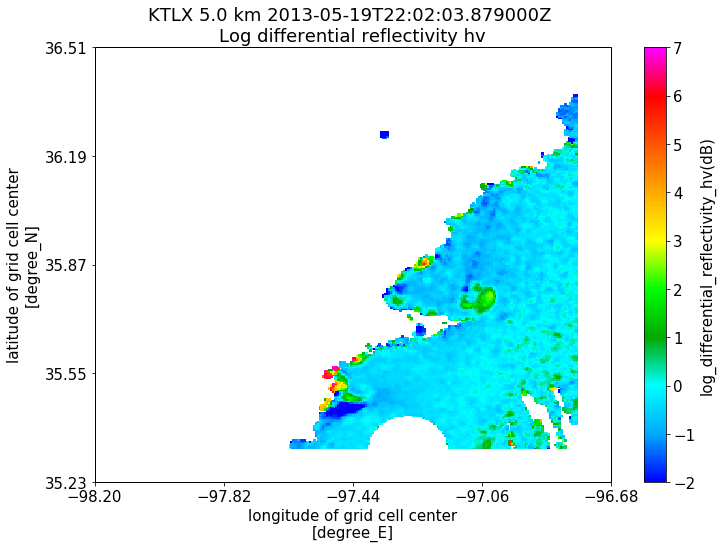

In [377]:
# display = pyart.graph.GridMapDisplay(grid)

# display.plot_grid('differential_reflectivity',level=10,cmap='pyart_RefDiff',vmin=-2,vmax=7)